In [1]:
import pandas as pd
import numpy as np

#from pycel import ExcelCompiler
import time
import seaborn as sns

import matplotlib.pyplot as plt

import random as rd

In [2]:
def Convert_Column_Times_To_Seconds(time_column):
    return_list = []
    for decimal_time in time_column:
        return_list.append(decimal_time * 24 * 3600)

    return return_list

In [3]:
def Convert_Column_Times_to_Format(time_column):
    return_list = []
    for timestamp in time_column:
        return_list.append(time.strftime('%H:%M:%S', time.gmtime(timestamp)))

    return return_list    

In [4]:
def move_column_inplace(df, col, pos):
    col = df.pop(col)
    df.insert(pos, col.name, col)

    return df

In [5]:
# If True, the Excel model is evaluated again, and exported to CSV as cache. If False, cached CSV files are used.
# However, this does not work for other aircraft types than the A320 due to incompatibility with the Excel model and the Pycel library.
# CSV files have to be exported manually for each aircraft from the model.

generate_model_cache = False

aircraft_types = ["A332", "A333", "A350", "A380", "B788", "B77W", "B748"]

# Using capacity used by airlines, can differ per configuration, here we could also add seats in the three classes: First, Business, Economy
aircraft_seat_capacity_dict = {
    "A332": 224, # https://www.airfranceklm.com/en/fleet/long-courrier/airbus-a330-200
     "A333": 292, # https://www.airfranceklm.com/en/fleet/long-courrier/airbus-a330-300
     "A350": 324, # https://www.airfranceklm.com/en/fleet/long-courrier/airbus-a350-900
     "A380": 615, # https://www.emirates.com/english/experience/our-fleet/a380/
     "B788": 240, # https://www.ana.co.jp/en/jp/international/departure/inflight/seatmap/detail/b787_8.html
     "B77W": 468, # https://www.airfranceklm.com/en/fleet/long-courrier/boeing-777-300er
     "B748": 364 # https://www.lufthansa.com/is/en/74h
}

In [6]:
# Evaluate model and store results in dataframe, and export CSV file as cache

# Theoretically, the following approach works. However, the results from the Excel sheet only give the emissions for the Airbus A320, even when switched to other aircraft.
# Therefore, the CSV cache files are created manually and imported

if(generate_model_cache == True):

    flight_df_dict = {}

    # Column names of emissions Dataframe
    column_names = ["Distance [nm]", "Cruise flight level [100 ft]", "Duration [Excel]", "Fuel burn [kg]", "CO2 [kg]", "NOx [kg]", "SOx [kg]", "H2O [kg]", "CO [kg]", "HC [kg]", "PM non volatile [kg]", "PM volatile [kg]", "PM total [kg]"]

    model_path = "model/EEAEmissionsCalculator.xlsm"
    model = ExcelCompiler(filename=model_path)

    for aircraft_type in aircraft_types:

        print("Previous aircraft setting: {}".format(model.evaluate('Emissions calculator!D17')))

        # Set settings in Excel model to aircraft type
        model.set_value('Emissions calculator!D17', aircraft_type)

        print("Aircraft setting: {}".format(model.evaluate('Emissions calculator!D17')))

        # Evaluate model for this aircraft type and store results in dictionary
        evaluation_results = model.evaluate('Emissions calculator!D33:P42')
        evaluation_results_df = pd.DataFrame.from_dict(evaluation_results)
        evaluation_results_df.columns = column_names

        # Convert times to seconds
        evaluation_results_df.insert(loc=0, column='Duration [s]', value=Convert_Column_Times_To_Seconds(evaluation_results_df["Duration [Excel]"]))

        # Adding rows of zeros to set initial condition for further calculations
        evaluation_results_df.loc[-1] = ['0','0','0','0','0','0','0','0','0','0','0','0','0','0']
        evaluation_results_df.index = evaluation_results_df.index + 1 # shifting index
        evaluation_results_df = evaluation_results_df.sort_index()  # sorting by index
        evaluation_results_df = evaluation_results_df.apply(pd.to_numeric(errors='coerce'))

        # Excel time format is no longer needed
        evaluation_results_df = evaluation_results_df.drop(columns='Duration [Excel]')

        # Store CSV for cache purposes
        evaluation_results_df.to_csv("model/{}.csv".format(aircraft_type))

        flight_df_dict[aircraft_type] = evaluation_results_df
    


In [7]:
def Load_Aircraft_Data(aircraft_type):
    """Loads cached CSV file from Excel model that contains emissions data. Those cache files are created manually from the Excel model."""
    import_df = pd.read_csv("model/{}.csv".format(aircraft_type), index_col=0)
    
    # Convert times to seconds
    import_df.insert(loc=0, column='Duration [s]', value=Convert_Column_Times_To_Seconds(import_df["Duration [Excel]"]))

    # Adding rows of zeros to set initial condition for further calculations
    import_df.loc[-1] = ['0','0','0','0','0','0','0','0','0','0','0','0','0','0']
    import_df.index = import_df.index + 1 # shifting index
    import_df = import_df.sort_index()  # sorting by index
    import_df = import_df.apply(pd.to_numeric)

    # Excel time format is no longer needed
    import_df = import_df.drop(columns='Duration [Excel]')

    return import_df

In [8]:
def Fetch_Rows_For_Interpolation(flight_df, time_given):
    """Fetches the two rows in the data next to the given time (closest lower than given time and closest higher than given time), used for linear interpolation"""
    
    independent_variable_column = 'Duration [s]'

    df_mask = flight_df[independent_variable_column] <= time_given

    # Get last row where time is lower than given time
    flight_df_lower_bound = flight_df[df_mask].iloc[-1:]
    
    # Init empty Dataframe
    flight_df_interval = pd.DataFrame()

    index_lower_bound = flight_df_lower_bound.iloc[0:].index

    # Corner case: If index of lower bound is equal or higher than index of highest value in column, the index goes out of bounds for the upper bound
    # Then, no result dataframe is returned
    if(index_lower_bound >= flight_df[independent_variable_column].idxmax()):
        result_success = False
    else:
        # Look up position of index in non-filtered dataframe
        loc_lower_bound = flight_df.index.get_loc(index_lower_bound[0])

        # Upper bound is one position (row) higher in Dataframe
        loc_upper_bound = loc_lower_bound + 1

        flight_df_upper_bound = flight_df.iloc[[loc_upper_bound]]

        df_list = [flight_df_lower_bound, flight_df_upper_bound]
        flight_df_interval = pd.concat(df_list)

        result_success = True

    return result_success, flight_df_interval

In [9]:
def Interpolate_Emissions(flight_df, given_times):
    """Receives list of time points for which emissions are to be interpolated
    :return: Dataframe with emissions for each time point
    """
    df_list = []

    for given_time in given_times:

        # Get data higher and lower than given time
        result_success, flight_df_interval = Fetch_Rows_For_Interpolation(flight_df, given_time)

        # Catch corner case to avoid exception. If time value is out of bounds, return nothing and print to console.

        if(result_success == True):
            # Init dictionary
            emissions_at_time = {}

            x = given_time

            # Iterate through columns to interpolate each of them individually
            for (column_name, column_data) in flight_df_interval.iteritems():

                # Get x values (times) as interpolation boundaries on x-axis
                if(column_name == "Duration [s]"):
                    x1 = flight_df_interval["Duration [s]"].iloc[0]
                    x2 = flight_df_interval["Duration [s]"].iloc[1]

                y1 = column_data.iloc[0]
                y2 = column_data.iloc[1]

                # Linear interpolation
                y = y1 + (x - x1)*((y2-y1)/(x2-x1))

                # Store interpolated column value to dictionary
                emissions_at_time[column_name] = [y]

            emissions_at_time_df = pd.DataFrame.from_dict(emissions_at_time)
            emissions_at_time_df.insert(loc=1, column='Duration [hh:mm:ss]', value=Convert_Column_Times_to_Format(emissions_at_time_df["Duration [s]"]))

            df_list.append(emissions_at_time_df)
    
    if(len(df_list) != 0):
        emissions_at_times_df = pd.concat(df_list, ignore_index=True)
    else:
        # Return empty dataframe
        emissions_at_times_df = pd.DataFrame()

    return emissions_at_times_df


In [10]:
def Get_Emissions_At_Times(aircraft_type, given_times):
    aircraft_df = Load_Aircraft_Data(aircraft_type)
    emissions_at_times_df = Interpolate_Emissions(aircraft_df, given_times)

    return emissions_at_times_df

# Examples

## Get emissions data from A350 at desired times

This can be integrated into the dashboard. 

In [73]:
# Create time range between 0 and 6 hours of flight, with 5 minute intervals (5*60 seconds)
desired_times = range(0, (6 * 60 * 60) + (5 * 60), (1 * 60))

output_emissions_at_times_df = Get_Emissions_At_Times("B748", desired_times)

In [70]:
output_emissions_at_times_df

,Duration [s],Duration [hh:mm:ss],Distance [nm],Cruise flight level [100 ft],Fuel burn [kg],CO2 [kg],NOx [kg],SOx [kg],H2O [kg],CO [kg],...,Fuel burn [kg] Lag,CO2 [kg] Lag,NOx [kg] Lag,SOx [kg] Lag,H2O [kg] Lag,CO [kg] Lag,HC [kg] Lag,PM non volatile [kg] Lag,PM volatile [kg] Lag,PM total [kg] Lag
0,0.0,00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,60.0,00:01:00,6.195698,8.921806,175.960783,554.276466,3.145806,0.147807,216.431990,0.527839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,120.0,00:02:00,12.391397,17.843611,351.921565,1108.552931,6.291612,0.295614,432.863980,1.055679,...,175.960783,554.276466,3.145806,0.147807,216.431990,0.527839,0.017102,0.000022,0.011047,0.011070
3,180.0,00:03:00,18.587095,26.765417,527.882348,1662.829397,9.437419,0.443422,649.295970,1.583518,...,351.921565,1108.552931,6.291612,0.295614,432.863980,1.055679,0.034203,0.000045,0.022095,0.022139
4,240.0,00:04:00,24.782793,35.687222,703.843131,2217.105862,12.583225,0.591229,865.727959,2.111358,...,527.882348,1662.829397,9.437419,0.443422,649.295970,1.583518,0.051305,0.000067,0.033142,0.033209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,21600.0,06:00:00,2858.050453,400.000000,60406.410994,190280.194619,720.291725,50.741380,74299.818194,77.840017,...,60233.327584,189734.981880,718.287128,50.595989,74086.926511,77.629784,2.883183,0.000420,6.264309,6.264729
361,21660.0,06:01:00,2866.070119,400.000000,60579.494403,190825.407358,722.296323,50.886771,74512.709877,78.050250,...,60406.410994,190280.194619,720.291725,50.741380,74299.818194,77.840017,2.889517,0.000420,6.280560,6.280980
362,21720.0,06:02:00,2874.089786,400.000000,60752.577813,191370.620097,724.300920,51.032162,74725.601559,78.260484,...,60579.494403,190825.407358,722.296323,50.886771,74512.709877,78.050250,2.895851,0.000420,6.296810,6.297230
363,21780.0,06:03:00,2882.109453,400.000000,60925.661222,191915.832836,726.305517,51.177553,74938.493242,78.470717,...,60752.577813,191370.620097,724.300920,51.032162,74725.601559,78.260484,2.902184,0.000420,6.313061,6.313481


In [77]:
def Create_Non_Comulative_Emissions(emissions_df):

    input_df = emissions_df.copy(deep=True)

    emissions_non_comulative_df = pd.DataFrame()

    for column_name in emissions_df:
        if(column_name not in ["Duration [s]", "Duration [hh:mm:ss]", "Distance [nm]", "Cruise flight level [100 ft]"]):
            print(column_name)
            
            column_name_lag = column_name + " Lag"

            input_df[column_name_lag] = input_df[column_name].shift(1).fillna(0)
            emissions_non_comulative_df[column_name] = input_df[column_name] - input_df[column_name_lag]

            # Add a little randomness to make data look more realistic
            for ind in emissions_non_comulative_df.index:
                column_mean_int = int(emissions_non_comulative_df[column_name].mean())
                emissions_non_comulative_df.loc[ind, column_name] = emissions_non_comulative_df.loc[ind, column_name] + 0.15*rd.randint(0, column_mean_int)

    return emissions_non_comulative_df

In [72]:
output_emissions_at_times_df

,Duration [s],Duration [hh:mm:ss],Distance [nm],Cruise flight level [100 ft],Fuel burn [kg],CO2 [kg],NOx [kg],SOx [kg],H2O [kg],CO [kg],...,Fuel burn [kg] Lag,CO2 [kg] Lag,NOx [kg] Lag,SOx [kg] Lag,H2O [kg] Lag,CO [kg] Lag,HC [kg] Lag,PM non volatile [kg] Lag,PM volatile [kg] Lag,PM total [kg] Lag
0,0.0,00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,60.0,00:01:00,6.195698,8.921806,175.960783,554.276466,3.145806,0.147807,216.431990,0.527839,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,120.0,00:02:00,12.391397,17.843611,351.921565,1108.552931,6.291612,0.295614,432.863980,1.055679,...,175.960783,554.276466,3.145806,0.147807,216.431990,0.527839,0.017102,0.000022,0.011047,0.011070
3,180.0,00:03:00,18.587095,26.765417,527.882348,1662.829397,9.437419,0.443422,649.295970,1.583518,...,351.921565,1108.552931,6.291612,0.295614,432.863980,1.055679,0.034203,0.000045,0.022095,0.022139
4,240.0,00:04:00,24.782793,35.687222,703.843131,2217.105862,12.583225,0.591229,865.727959,2.111358,...,527.882348,1662.829397,9.437419,0.443422,649.295970,1.583518,0.051305,0.000067,0.033142,0.033209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,21600.0,06:00:00,2858.050453,400.000000,60406.410994,190280.194619,720.291725,50.741380,74299.818194,77.840017,...,60233.327584,189734.981880,718.287128,50.595989,74086.926511,77.629784,2.883183,0.000420,6.264309,6.264729
361,21660.0,06:01:00,2866.070119,400.000000,60579.494403,190825.407358,722.296323,50.886771,74512.709877,78.050250,...,60406.410994,190280.194619,720.291725,50.741380,74299.818194,77.840017,2.889517,0.000420,6.280560,6.280980
362,21720.0,06:02:00,2874.089786,400.000000,60752.577813,191370.620097,724.300920,51.032162,74725.601559,78.260484,...,60579.494403,190825.407358,722.296323,50.886771,74512.709877,78.050250,2.895851,0.000420,6.296810,6.297230
363,21780.0,06:03:00,2882.109453,400.000000,60925.661222,191915.832836,726.305517,51.177553,74938.493242,78.470717,...,60752.577813,191370.620097,724.300920,51.032162,74725.601559,78.260484,2.902184,0.000420,6.313061,6.313481


In [78]:
emissions_non_comulative_df = Create_Non_Comulative_Emissions(output_emissions_at_times_df)

Fuel burn [kg]
CO2 [kg]
NOx [kg]
SOx [kg]
H2O [kg]
CO [kg]
HC [kg]
PM non volatile [kg]
PM volatile [kg]
PM total [kg]


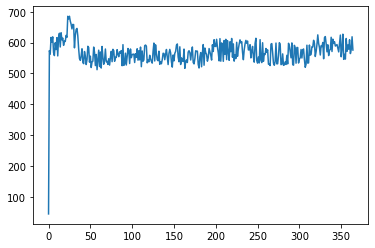

In [79]:
plt.plot(emissions_non_comulative_df.index, emissions_non_comulative_df["CO2 [kg]"])

## Get emissions for all available aircraft at desired times

The dataframes of emissions at desired times are stored in dictionary.

In [ ]:
emissions_df_all_aircraft_dict = {}

for aircraft_type in aircraft_types:
    output_emissions_at_times_df = Get_Emissions_At_Times(aircraft_type, desired_times)

    print(aircraft_type)
    emissions_df_all_aircraft_dict[aircraft_type] = output_emissions_at_times_df

Now, they can be read easily without the need to generate the Dataframes again.

In [ ]:
def Plot_Aircraft_Emissions(aircraft_type):
    emissions_at_times_df = emissions_df_all_aircraft_dict[aircraft_type]
    
    plot_column_list = ["Fuel burn [kg]", "CO2 [kg]"] #["Distance [nm]", "Fuel burn [kg]", "CO2 [kg]", "H2O [kg]"]
    seaborn_df = pd.melt(emissions_at_times_df, id_vars = ["Duration [s]"], value_vars = plot_column_list)
    seaborn_df = seaborn_df.rename(columns = {'value' : 'Parameter value', 'variable': 'Parameter'})

    flight_plot = sns.lineplot(x = "Duration [s]", y = 'Parameter value', hue = 'Parameter', data = seaborn_df, palette = 'tab10')
    flight_plot.set(yscale='log', ylim=(10E2, 10E5))

    max_CO2_value = emissions_at_times_df["CO2 [kg]"].max() 
    aircraft_seat_capacity = aircraft_seat_capacity_dict[aircraft_type]

    print("Total CO2 emissions at end of flight time: {:.2f} kg CO2".format(max_CO2_value))
    print("CO2 emissions per passenger at full occupancy: {:.2f} kg CO2".format(max_CO2_value/aircraft_seat_capacity))
    print("CO2 emissions per passenger at half occupancy: {:.2f} kg CO2".format(max_CO2_value/(aircraft_seat_capacity / 2)))
    print("CO2 emissions per passenger at 200 passengers: {:.2f} kg CO2".format(max_CO2_value/(200)))



In [ ]:
Plot_Aircraft_Emissions("A380")

In [ ]:
Plot_Aircraft_Emissions("A350")

In [ ]:
Plot_Aircraft_Emissions("B748")

# Notes

## EEA Model
Manipulating the EEA Aviation Emissions Calculator via the Python library PyCel is slow. Reading the "Climb, cruise, descent" stage length (NM) information from the Excel model for a flight with an Airbus A320 takes about 3.5 minutes.

The primary goal of this project is not the development of a Python implementation of the EEA Aviation Emissions Calculator. Therefore, we do not focus on increasing the excecution speed of the Excel model in Python. Instead, we cache the information. The model is executed in Excel with standard settings for each aircraft that should be covered by LCAero. The results (emissions) are cached in a CSV file that can be imported by a Python script without analyzing the spreadsheet again.

- Add simple explaination of EEA model to report, explain different flight phases, etc.
- Define LTO and CCD stage length

## Other life data

Flight cycles is very hard to determine as there are so many variables. Every airline has its own rules on this. There is not an x amount of maximum flying cycles a seat or galley is designed for. 
It also varies per product (seat, galley, lavatory etc) and sort of aircraft and mission (low cost vs. full service, long haul vs short/medium range).

A low cost airline has much more wear and tear on the seats, carpet (sometimes 8-10 short flight cycles a day) but these aircraft have less wear and tear on the galley as there is much less on board service and catering available and also less wear and tear on the lavatory since people use the bathroom less on short flights. 

So for example a Boeing 737 from KLM (full service airline with maybe max 4 flights a day with catering) will have a completely different interior replacement schedule than a Boeing 737 from Ryanair (low cost with maybe 8 to 10 flight a day and no catering) . 

Also there is a difference in long haul and short range. The latter has much more flying cycles and therefore the seats and carpets wear much faster as there are more people moving through the isle and using the overhead bins during one day. 

Seats and lavatories are usually replaced when the aircraft is checked during a C- check . This can be a certain time frame (e.g. 2 years) or 2000-3000 flight cycles.
Galleys are replaced during D-checks (every 10 years, or 10000-15000 cycles) but not per se during every D check. Depends on how long the airline is planning to continue flying with the A/C

So there is not a definitive answer on the number of flight cycles. 

Criteria like environmental performance is now being introduced within the airline industry. But it is very new for most. For some airlines ((Northern) Europe) this is  a factor that they take into account when replacing equipment. This applies especially to airlines that are (partially) owned by the local government as they usually set is as a requirement for new purchases. For others it is not important at all (Africa , Central Asia and Middle East).

I don’t have access to live data from A/C at the moment, same goes for emissions calculator.  Think this is also company confidential info. 
